# 1. 实战Kaggle比赛图像分类CIFAR10

① 比赛的网址是 https://www.kaggle.com/c/cifar-10

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch 
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
# 我们提供包含前1000个训练图像和5个随即测试图像的数据集的小规模样本
# cifar10_tiny是cifar10中每一个类把前面一千个训练图片拿出来，测试是每一个类挑五个图片
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                               '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
demo = True # 如果为True，则只使用训练集的小规模样本;如果为False，则使用完整的数据集

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10'

In [3]:
# 整理数据集
def read_csv_labels(fname):
    """读取 'fname' 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:] # 一行一行读进来，每一行为列表中一个元素;从1开始跳过表头
    # print('lines[:5]: ',lines[:5]) # 打印前5行
    tokens = [l.rstrip().split(',') for l in lines] # 遍历列表每一个元素，切分
    # print('tokens[:5]: ',tokens[:5]) # 打印前5行
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
labels

lines[:5]:  ['1,frog\n', '2,truck\n', '3,truck\n', '4,deer\n', '5,automobile\n']
tokens[:5]:  [['1', 'frog'], ['2', 'truck'], ['3', 'truck'], ['4', 'deer'], ['5', 'automobile']]


{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

In [4]:
# 将验证集从原始的训练集中拆分出来
# train文件夹下有所有train的图片，test文件夹下有所有test图片
# 把train文件夹下所有类的图片创建一个类名文件夹，然后搬到对应文件夹下
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir) 
    
def reorg_train_valid(data_dir, labels, valid_ratio):
    '''
    data_dir：包含训练和测试数据的根目录路径。
    labels：一个字典，键是文件名（不包含扩展名），值是对应的标签。
    valid_ratio：验证集占原始训练集的比例。
    '''

    '''
    使用 collections.Counter 统计 labels 中每个标签的数量，找出数量最少的标签，
    并计算每个标签对应的验证集大小 n_valid_per_label。
    '''
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1,math.floor(n * valid_ratio))

    # 初始化一个字典来记录每个标签的验证集文件数量
    label_count = {}
    # 遍历原始训练集目录下的所有文件
    for train_file in os.listdir(os.path.join(data_dir,'train')):
        # 从文件名中提取标签
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        
        # 将文件复制到train_valid目录下的对应标签文件夹
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        
        # 如果该标签的计数小于验证集大小，则复制到验证集目录
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # 否则复制到新的训练集目录
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))  
    return n_valid_per_label

In [5]:
# 在预测期间整理测试集，以方便读取
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir,'test')):
        copyfile(os.path.join(data_dir,'test',test_file),
                os.path.join(data_dir,'train_valid_test','test','unknown')) # unknown为 test文件夹里面的一个文件夹   

In [6]:
# 调用前面定义的函数，前面只是定义函数，这里是调用
def reorg_cifar10_data(data_dir,valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
    reorg_train_valid(data_dir,labels,valid_ratio)
    reorg_test(data_dir)
    
# 如果是demo模式，则batch_size为32，否则为128
batch_size = 32 if demo else 128
valid_ratio = 0.1 # train 数据里面百分之九十用来训练，剩下百分之十用来验证  
reorg_cifar10_data(data_dir, valid_ratio)

lines[:5]:  ['1,frog\n', '2,truck\n', '3,truck\n', '4,deer\n', '5,automobile\n']
tokens[:5]:  [['1', 'frog'], ['2', 'truck'], ['3', 'truck'], ['4', 'deer'], ['5', 'automobile']]


In [13]:
# 图像增广
# 定义训练集的图像增广方式
transform_train = torchvision.transforms.Compose([
    # 将图像大小调整为40x40
    torchvision.transforms.Resize(40),
    # 随机裁剪图像，裁剪后的图像大小为32x32，缩放范围为0.64到1.0，宽高比为1.0
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)),
    # 随机水平翻转图像
    torchvision.transforms.RandomHorizontalFlip(),
    # 将图像转换为Tensor
    torchvision.transforms.ToTensor(),
    # 对图像进行归一化，均值为[0.4914,0.4822,0.4465]，标准差为[0.2023,0.1994,0.2010]
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                   [0.2023,0.1994,0.2010]) ])

# 定义测试集的图像增广方式
transform_test = torchvision.transforms.Compose([
    # 将图像转换为Tensor
    torchvision.transforms.ToTensor(),
    # 对图像进行归一化，均值为[0.4914,0.4822,0.4465]，标准差为[0.2023,0.1994,0.2010]
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                    [0.2023,0.1994,0.2010]) ])

In [8]:
# 读取由原始图像组成的数据集
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir,'train_valid_test',folder),
        transform=transform_train) for folder in ['train','train_valid'] ]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir,'train_valid_test',folder),
        transform=transform_test) for folder in ['valid','test'] ]

In [9]:
# 指定上面定义的所有图像增广操作
# 创建训练集和验证集的数据加载器
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,drop_last=True)
    for dataset in (train_ds, train_valid_ds) ]

# 创建验证集的数据加载器
valid_iter = torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)    

# 创建测试集的数据加载器
test_iter = torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)     

In [10]:
# 模型
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes,3) # 3表示数值三通道，彩色图片
    return net

loss = nn.CrossEntropyLoss(reduction="none") # reduction="none" 表示不要把loss加起来sum

In [11]:
# 训练函数
def train(net, train_iter, valid_iter, num_epoch, lr, wd, devices, lr_period, lr_decay):  # 每隔一段时间的lr_period把学习率lr_decay降低点     
    trainer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay) 
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss','train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=legend)   
    net = nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)    
            metric.add(l,acc,labels.shape[0])
            timer.stop()
            if (i+1) % (num_batches // 5) == 0 or i == num_batches -1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0]/metric[2], metric[1]/metric[2],None))      
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net,valid_iter)
            animator.add(epoch+1,(None,None,valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f},'
               f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
         f' examples/sec on {str(devices)}')

train loss 0.608,train acc 0.782, valid acc 0.391
878.8 examples/sec on [device(type='cuda', index=0)]


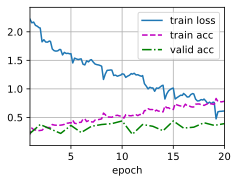

In [12]:
# 训练和验证模型
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 0.563,train acc 0.803
1092.4 examples/sec on [device(type='cuda', index=0)]


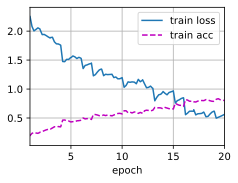

In [14]:
# 对测试集进行分类并提交结果
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)    
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1,len(test_ds)+1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id':sorted_ids,'label':preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv',index=False)